In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
from tqdm import tqdm
import matplotlib

Using TensorFlow backend.


Initialized TensorFlow


Problem: Taylor is WAY OFF for $np>1$...

Hypothesis: need to add second term to the mean as only MEAN is off and variance is fine.
Need to calculate $L''_{ii}$, diagonal of the Hessian

A bit better (for second layer) with it....

In [44]:
# tf._hessian_vector_product -- use for VarDelta regularization

In [3]:
# network configuration
N = [100, 50, 20]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, 0, p]  + [0] * (len(N) - 1)

# prob. of failure at inference
p_inf = 0.01
p_inference = get_p_arr(p_inf)

# prob. of failure at train
p_trains = np.linspace(0, 1.2 * p_inf, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 6

# number of runs for each p
runs = 10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total params: 84,780
Trainable params: 84,780
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 27us/step - loss: 42.9115 - categorical_accuracy: 0.5508 - mean_squared_error: 0.1023 - mean_absolute_error: 0.1917 - val_loss: 29.0437 - val_categorical_accur

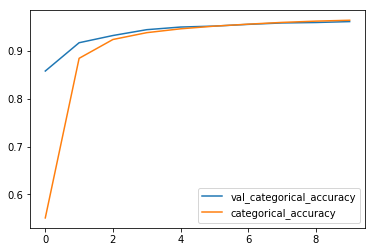

Creating network for 784-dimensional input and 10-dimensional output, with 3 hidden layers
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
Crashes (Lambda)             (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                210       
Total params: 84,780
Trainable params: 84,780
Non-trainable params: 0
_________________________________________________________________
_______________________________________________

In [4]:
exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = get_p_arr(0), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = 'balanced', reg_coeff = 1e-5, do_print = True,
                                      name = 'experiment_weights', seed = None, batch_size = 100)

In [5]:
truth = exp.y_train

In [6]:
def crashing_loss():
    prediction = exp.predict_crashing(exp.x_train, repetitions = 1)
    prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [7]:
def correct_loss():
    prediction = exp.predict_correct(exp.x_train)
    #prediction = prediction.reshape(60000, 10)
    loss = np.mean(np.square(prediction - truth))
    return loss

In [8]:
correct = correct_loss()

In [9]:
crashing = [crashing_loss() for _ in tqdm(range(20))]

100%|██████████| 20/20 [00:16<00:00,  1.26it/s]


In [10]:
correct * 1000

7.933752717404247

(array([1., 0., 2., 2., 3., 1., 4., 5., 1., 1.]),
 array([12.88515567, 12.90804635, 12.93093703, 12.95382772, 12.9767184 ,
        12.99960908, 13.02249976, 13.04539044, 13.06828112, 13.0911718 ,
        13.11406248]),
 <a list of 10 Patch objects>)

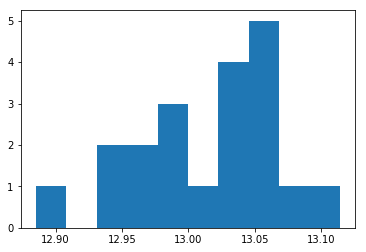

In [11]:
plt.hist(np.array(crashing) * 1000)

In [12]:
# 1. Experimental evaluation -> quite fast, doesn't ruin things much...

In [13]:
# computing probability delta of bad crash >= alpha

In [14]:
n = N[0]
t = p_inf * 3
alpha = (p_inf + t) ** 0.5
print(alpha)

0.2


In [15]:
def q_factor(array):
    """ q-balanced factor """
    array = np.abs(array)
    assert np.max(array) > 0, "Cannot compute q-factor for zero array"
        
    return np.min(array) / np.max(array)

In [16]:
q = q_factor(np.linalg.norm(exp.W[0], axis = 1) ** 2)

In [17]:
# Chernoff bound
delta = np.exp(-2*t**2*n)
delta

0.835270211411272

In [18]:
alpha ** 2

0.04000000000000001

In [19]:
# for CHEBYSHEV
print(np.mean(crashing))
print(np.std(crashing))
a = np.std(crashing) * 3

0.013016685690873938
5.5072680691963086e-05


In [20]:
# why is it negative and not equal to the experiment???
np.mean(exp._get_bound_b3_loss(exp.x_train, exp.y_train)['std'] ** 2)

AssertionError: Must have failures only at first layer, other options are not implemented yet

In [22]:
# a bit better with this new term...
self = exp

In [23]:
grad = []
grad_sq = []

# list of layers
layers = self.model_correct.layers

# loss tensor
loss = self.loss

In [33]:
# TODO: speedup quadratic computation...
W = layers[1].weights[0]
Wsq = tf.multiply(W, W)
S = 0.5 * p_inf * tf.reduce_sum(tf.multiply(Wsq, tf.linalg.tensor_diag_part(tf.reshape(tf.hessians([loss], W)[0], (*W.shape, *W.shape)))))
S1 = tf.reduce_sum(tf.multiply(W, tf.gradients([loss], W)[0])) * (-p_inf)

In [34]:
sess = get_session()

In [39]:
sess.run([S1,S,S1+S], feed_dict = {exp.output_tensor: y, exp.model_correct.input: x})

[-2.1644588e-05, 0.0018411456, 0.0018195009]

In [283]:
tf.gradients([loss], [layers[0].output])[0]

<tf.Tensor 'gradients_70/dense_8/MatMul_grad/MatMul:0' shape=(?, 1000) dtype=float32>

In [105]:
# w.r.t. first layer output
grad    += [tf.reduce_sum(          tf.multiply(tf.gradients([loss], [layers[0].output])[0], layers[0].output), axis = 1)]
grad_sq += [tf.reduce_sum(tf.square(tf.multiply(tf.gradients([loss], [layers[0].output])[0], layers[0].output)), axis = 1)]

In [32]:
grad_sq

[]

In [27]:
### Trying for a single object...
x = exp.x_train[0:1]
y = exp.y_train[0:1]

In [40]:
crashing = exp.predict_crashing(x, repetitions = 10000)#.reshape(1000, 10)
correct = exp.predict_correct(x)

In [41]:
np.mean(np.square(crashing - y))

0.018414757601089717

In [42]:
np.mean(np.square(correct - y))

0.012076890994369599

In [43]:
# here crashing error is bigger than correct
np.mean(np.square(crashing - y)) - np.mean(np.square(correct - y))

0.006337866606720118

In [313]:
# WTF? here crashing error is less than correct...
exp._get_bound_b3_loss(x, y)['std']

array([[0.00598168]], dtype=float32)

In [314]:
# mean crashing - correct
np.mean(crashing, axis = 1) - correct

IndexError: tuple index out of range

In [245]:
exp.get_bound_b3(x)['mean']

array([[-2.9216204e-05, -5.7966111e-04,  3.7183922e-03,  4.1817925e-03,
        -3.5907721e-04, -3.0232130e-03, -2.8021978e-03,  5.3408160e-04,
        -2.0106067e-03, -8.1715413e-04]], dtype=float32)

In [246]:
y

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])